## Resnet

Here is the resnet architecture depiction from the original paper. Note that the input is assumed to be of an image of size 224 x 224. Further, every convolution is followed by batch normalization.

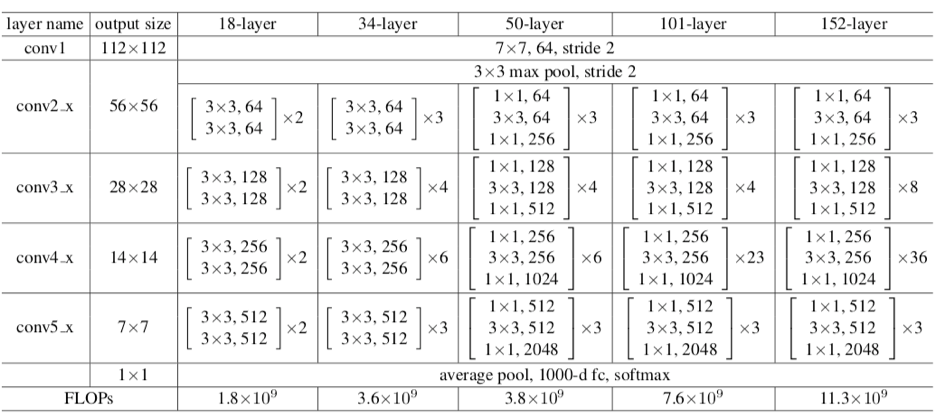

###Observation 1
All variants of resnet have the a common 7 x 7 convolution followed by max pool. We will group these operations under the class Layer1.


In [ ]:
import torch
import torch.nn as nn

In [ ]:
class Layer1(nn.Module):
  def __init__(self, in_channels=3):
    super().__init__()
    self.out_channels = 64
    self.in_channels = in_channels
    self.conv1=nn.Conv2d(in_channels,self.out_channels, kernel_size=7,stride=2, padding=3,bias=False)
    self.batch_norm=nn.BatchNorm2d(self.out_channels)
    self.relu=nn.ReLU()
    self.maxpool=nn.MaxPool2d(kernel_size=3, stride=2,padding=1)


  def forward(self, x):
    x=self.conv1(x)
    x=self.batch_norm(x)
    x=self.relu(x)
    x=self.maxpool(x)
    return x


###More Observations
- All variants have four more layers namely conv2_x, ..., conv5_x.
- Each layer has multiple residual blocks consisting of couple or triple of convolutions.
- There are two types of residual block viz. one what we see in resnet-18 and resnet-34, and the other which is seen in resnet-50, resnet-101 and resnet-152. We will call the former BasicBlock and the latter BottleNeck.
- Layer2 (i.e conv2_x) retains the incoming spatial size (56 x 56). Other subsequent layers downsample the spatial size by a factor of 2 respectively.
- This downsampling is effected in the first convolution of first BasicBlock / second convolution of first Bottleneck within the layer using a stride of 2. Accordingly, along the skip connection in the first residual block in the layer, downsampling must be done(using a 1 x 1 convolution with a stride of 2).
- Other residual blocks within the layer retain the spatial size that is coming out of first residual block.
- When the layers are made up of residual blocks of type BasicBlock, in each layer (from layer 3 onwards), the number of feature maps / outchannels double from what it was in the previous layer. This doubling happens in the first convolution in the first BasicBlock of the layer. The second convolution in the first BasicBlock and the rest of the residual blocks of type BasicBlock retain the incoming number of feature maps. Accordingly, along the skip connection in the first BasicBlock of the layer, the number of channels must be doubled.
- When the layers are made up of residual blocks of type Bottleneck, in each layer (from layer 2 / 3 onwards), the number of feature maps increase by factor of 4 / 2 from what what comes out from the previous layer. This happens as follows. In the first Bottleneck in the layer, the first convolution reduces the incoming number of channels by 2 (except in layer 2 where the incoming number of channels is retained), the second convolution retains the number of channels coming from the first, and the third quadraples the incoming number of channels. The other blocks of type Bottleneck within the layer reduces by factor of 4 the incoming channels in the first convolution, retains the number of incoming channels in the second convolution and quadraples it in the third convolution. Note that along the skip connection in the first Bottleneck of the layer, the number of channels must be accordingly adjusted.

Based on the observations, first we will define BasicBlock.

In [ ]:
class BasicBlock(nn.Module):
  def __init__(self, in_channels, is_first_block=False, is_layer_2=False, skip=True): # skip true means resnet i.e skip connections are present; else plain net
    super().__init__()

    self.in_channels = in_channels
    self.is_first_block = is_first_block
    self.is_layer_2 = is_layer_2
    self.skip = skip
    if self.is_layer_2:
      self.out_channels=self.in_channels
    else:
      if self.is_first_block:
        self.out_channels=self.in_channels * 2
      else:
        self.out_channels = self.in_channels


    # self.stride = 1 if not self.is_first_block or self.is_layer_2 else 2
    if self.is_layer_2:
      self.stride = 1
    else:
      if self.is_first_block:
        self.stride = 2
      else:
        self.stride = 1

    self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=self.stride,padding=1,bias=False)
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.conv2 = nn.Conv2d(in_channels,self.out_channels, kernel_size=3, stride=1,padding=1,bias=False)
    self.bn2 = nn.BatchNorm2d(self.out_channels)
    self.relu = nn.ReLU()

    if self.skip and not self.is_layer_2 and self.is_first_block:
      self.downsample_along_skip = True
      self.downsample_along_skip_conv = nn.Conv2d(in_channels, self.out_channels, kernel_size=1, stride=2, bias=False)
      self.downsample_along_skip_bn = nn.BatchNorm2d(self.out_channels)
    else:
      self.downsample_along_skip = False

  def forward(self, x):
        residual = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.skip:
          if self.downsample_along_skip:
            residual = self.downsample_along_skip_conv(residual)
            residual = self.downsample_along_skip_bn(residual)

          x = x + residual
        x = self.relu(x)
        return x


In [ ]:
print(torch.cuda.is_available())

True


Now we will define Bottleneck.

In [ ]:
class Bottleneck(nn.Module):
  def __init__(self, in_channels, is_first_block=False, is_layer_2=False, skip=True):
    super().__init__()

    self.in_channels = in_channels
    self.is_first_block = is_first_block
    self.is_layer_2 = is_layer_2
    self.skip = skip

    # write code below to get self.out_channels_1 where self.out_channels_1 is the number of outchannels in the first convolution of this residual block
    if self.is_layer_2 and self.is_first_block:
      self.out_channels_1=self.in_channels
    else:
      if self.is_first_block:
        self.out_channels_1 = self.in_channels//2
      else:
        self.out_channels_1=self.in_channels//4

    if self.is_layer_2 and self.is_first_block:
      self.out_channels = self.in_channels
    else:
      if self.is_first_block:
        self.out_channels = self.in_channels * 2
      else:
        self.out_channels = self.in_channels * 4

    if is_layer_2:
      self.stride=1
    else:
      if is_first_block:
        self.stride = 2
      else:
        self.stride = 1
    # fill here where self.out_channels is the number of outchannels in the last convolution of this residual block

    self.conv1 = nn.Conv2d(in_channels, self.out_channels_1, kernel_size=1, stride=1, bias=False)
    self.bn1 = nn.BatchNorm2d(self.out_channels_1)
    self.conv2 = nn.Conv2d(self.out_channels_1, self.out_channels_1, kernel_size=3, stride=self.stride, padding=1)
    self.bn2 = nn.BatchNorm2d(self.out_channels_1)
    self.conv3 = nn.Conv2d(self.out_channels_1, self.out_channels, kernel_size=1, stride=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.out_channels)
    self.relu = nn.ReLU()

    if self.skip and self.is_first_block: # note that even for layer2, even though there is no downsampling, the number of channels quadraples in the first block; that's why the condition here
                            # is just on is_first_block and not on is_layer_2; the stride is correctly available in self.stride
      self.downsample_along_skip = True
      self.downsample_along_skip_conv = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=self.stride, bias=False)
      self.downsample_along_skip_bn = nn.BatchNorm2d(self.out_channels)
    else:
      self.downsample_along_skip = False

  def forward(self, x):
        residual = x

        # Pass through bottleneck layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        # Apply downsampling to residual if needed
        if self.skip:
          if self.downsample_along_skip:
            residual = self.downsample_along_skip_conv(residual)
            residual = self.downsample_along_skip_bn(residual)

        # Add residual connection
          x = x + residual

        # Apply ReLU activation
        output = self.relu(x)
        return output

Now that we have coded our observations regarding BasicBlock and Bottleneck, we will define the ResNet as a network made up of layers of residual blocks.

In [ ]:
class ResNet(nn.Module):
  def __init__(self, res_block_type, num_blocks_per_layer, num_classes, in_channels=3, skip=True):
    # res_block_type is either BasicBlock or Bottleneck
    # num_blocks_per_layer is a list consisting of number of residual blocks in each layer from layer 2 to layer 5
    super().__init__()

    self.res_block_type = res_block_type
    self.num_blocks_per_layer = num_blocks_per_layer
    self.num_classes = num_classes
    self.skip=skip

    self.layer1 = Layer1(in_channels)
    self.layer2 = self._build_layer(res_block_type, num_blocks_per_layer[0], self.layer1.out_channels, True)
    self.layer3 = self._build_layer(res_block_type, num_blocks_per_layer[1], self.layer2[-1].out_channels, False)
    self.layer4 = self._build_layer(res_block_type, num_blocks_per_layer[2], self.layer3[-1].out_channels, False)
    self.layer5 = self._build_layer(res_block_type, num_blocks_per_layer[3], self.layer4[-1].out_channels, False)

    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.fc_layer_in_channels = self.layer5[-1].out_channels
    self.fc = nn.Linear(self.fc_layer_in_channels, self.num_classes)

  def _build_layer(self, res_block_type, nblocks, in_channels, is_layer_2):
    layer = []
    for i in range(nblocks):
      is_first_block = True if i == 0 else False
      block = res_block_type(in_channels, is_first_block, is_layer_2, self.skip)
      layer.append(block)
      in_channels = block.out_channels

    return nn.Sequential(*layer)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)

    x = self.avg_pool(x)
    x = torch.flatten(x,1)
    x = self.fc(x)
    return x



Let's now define resnet variants.

In [ ]:
def resnet18(in_channels=3, num_classes=10, skip=True):
  return ResNet(BasicBlock, [2, 2, 2, 2], num_classes, in_channels, skip)

def resnet34(in_channels=3, num_classes=10, skip=True):
  return ResNet(BasicBlock, [3, 4, 6, 3], num_classes, in_channels, skip)

def resnet50(in_channels=3, num_classes=10, skip=True):
  return ResNet(Bottleneck, [3, 4, 6, 3], num_classes, in_channels, skip)

def resnet101(in_channels=3, num_classes=10, skip=True):
  return ResNet(Bottleneck, [3, 4, 23, 3], num_classes, in_channels, skip)

def resnet152(in_channels=3, num_classes=10, skip=True):
  return ResNet(Bottleneck, [3, 8, 36, 3], num_classes, in_channels, skip)

model = resnet18(num_classes=1000)


Let's train resnet on MNIST dataset.

First, we will download the dataset and set up the train and test loaders.

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/100_utilities/datasets', download=True, train=True, transform=transform)
testset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/100_utilities/datasets', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 97107521.22it/s]


Extracting /content/drive/MyDrive/100_utilities/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/100_utilities/datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42653413.32it/s]


Extracting /content/drive/MyDrive/100_utilities/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/100_utilities/datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40810868.49it/s]

Extracting /content/drive/MyDrive/100_utilities/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/100_utilities/datasets/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 10117115.65it/s]


Extracting /content/drive/MyDrive/100_utilities/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/100_utilities/datasets/MNIST/raw



Next, we will define the model, loss criterion and the optimizer.

In [ ]:
import torch.optim as optim

model = resnet34(in_channels=1, num_classes=10)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(params=model.parameters(), lr=0.01)

Let's define the train loop.

In [ ]:
import torch.nn.functional as F
from tqdm import tqdm

def train_epoch(model, criterion, optimizer, train_loader, val_loader, epoch, device):
  loss_train, loss_val = 0., 0.
  acc_train, acc_val = 0., 0.
  ntrain = len(train_loader.dataset)
  nval = len(val_loader.dataset)

  with tqdm(train_loader, unit='batches') as pbar:
    for i, (images, labels) in enumerate(pbar):
      pbar.set_description(f"Epoch {epoch}")
      images = images.to(device)
      labels = labels.to(device).to(torch.long).view(-1)

      # train and back-propagate
      optimizer.zero_grad()
      output = model(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()

      # train accuracy
      with torch.no_grad():
        probs = F.softmax(output, dim=1).cpu()
        preds = torch.max(probs, dim=1)[1]
        acc_train += (preds == labels.cpu()).sum()
        loss_train += loss.item()

      #validate
      if i%100 == 0 or i == len(train_loader) - 1:
        loss_val, acc_val = validate(model, criterion, val_loader, device)

      if i < len(train_loader) - 1:
        denom = images.shape[0] * (i+1)
      else:
        denom = ntrain

      pbar.set_postfix(train_loss=loss_train/denom, valid_loss=loss_val/nval, train_acc=acc_train/denom, valid_acc=acc_val/nval)

  return loss_train/ntrain, loss_val/nval, acc_train/ntrain, acc_val/nval

def validate(model, criterion, val_loader, device):
  acc_val = 0.
  loss_val = 0.
  with torch.no_grad():
    for val_images, val_labels in val_loader:
      val_images = val_images.to(device)
      val_labels = val_labels.to(device).to(torch.long).view(-1)

      val_output = model(val_images)
      val_loss = criterion(val_output, val_labels)
      loss_val += val_loss.item()

      probs = F.softmax(val_output, dim=1).cpu()
      preds = torch.max(probs, dim=1)[1]
      acc_val += (preds == val_labels.cpu()).sum()

  return loss_val, acc_val

def train(model, criterion, optimizer, train_loader, val_loader, epochs, device):
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []

  for epoch in range(epochs):
    train_loss, val_loss, train_acc, val_acc = train_epoch(model, criterion, optimizer, train_loader, val_loader, epoch, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

  return train_losses, val_losses, train_accs, val_accs


Resnet 18

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
citerion = criterion.to(device)
epochs = 2

train_losses, val_losses, train_accs, val_accs = train(model, criterion, optimizer, trainloader, testloader, epochs, device)

Epoch 0: 100%|██████████| 469/469 [03:37<00:00,  2.15batches/s, train_acc=tensor(0.6567), train_loss=1.26, valid_acc=tensor(0.9683), valid_loss=0.0966]

Epoch 1: 100%|██████████| 469/469 [03:35<00:00,  2.17batches/s, train_acc=tensor(0.9758), train_loss=0.0807, valid_acc=tensor(0.9885), valid_loss=0.0366]


Resnet 34

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
citerion = criterion.to(device)
epochs = 2

train_losses, val_losses, train_accs, val_accs = train(model, criterion, optimizer, trainloader, testloader, epochs, device)

Epoch 1: 100%|██████████| 469/469 [03:04<00:00,  2.54batches/s, train_acc=tensor(0.9664), train_loss=0.114, valid_acc=tensor(0.9764), valid_loss=0.0774]


In [ ]:
!pip install torchsummary
from torchsummary import summary
summary(model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Layer1-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]          36,864
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
       BasicBlock-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
      BatchNorm2d-14           [-1, 64,

In [ ]:
plain_model = resnet18(in_channels = 1, num_classes = 10, skip = False)# fill here
# summary(plain_model, input_size=(3, 224, 224))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
plain_model = plain_model.to(device)
citerion = criterion.to(device)
epochs = 10

# train_losses, val_losses, train_accs, val_accs = train(model, criterion, optimizer, trainloader, testloader, epochs, device)

In [ ]:
from torchsummary import summary
summary(plain_model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Layer1-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]          36,864
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
       BasicBlock-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
      BatchNorm2d-14           [-1, 64,

# ImageNet


In [ ]:
!pip install torch torchvision

In [ ]:
import torch
import torchvision.models as models

In [ ]:
torch.cuda.is_available()

True

In [ ]:
model = models.GoogLeNet(1000)

/opt/conda/lib/python3.10/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [ ]:
print(model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
import torch
import torch.nn as nn

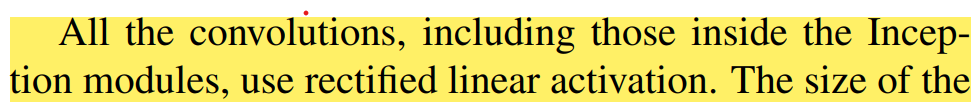

To mitigate the vanishing gradient problem, we are using batchNormalization

In [ ]:
class Conv(nn.Module):
  def __init__(self, in_channels, out_channels, kernelSize, stride, padding ):
    super(Conv,self).__init__()

    self.conv = nn.Conv2d(in_channels, out_channels, kernelSize, stride, padding)
    self.bn = nn.BatchNorm2d(out_channels)
    self.activation = nn.ReLU()

  def forward(self, x):
    x=self.conv(x)
    x=self.bn(x)
    x=self.activation(x)
#     x=self.conv(self.bn(self.activation(x)))
    return x

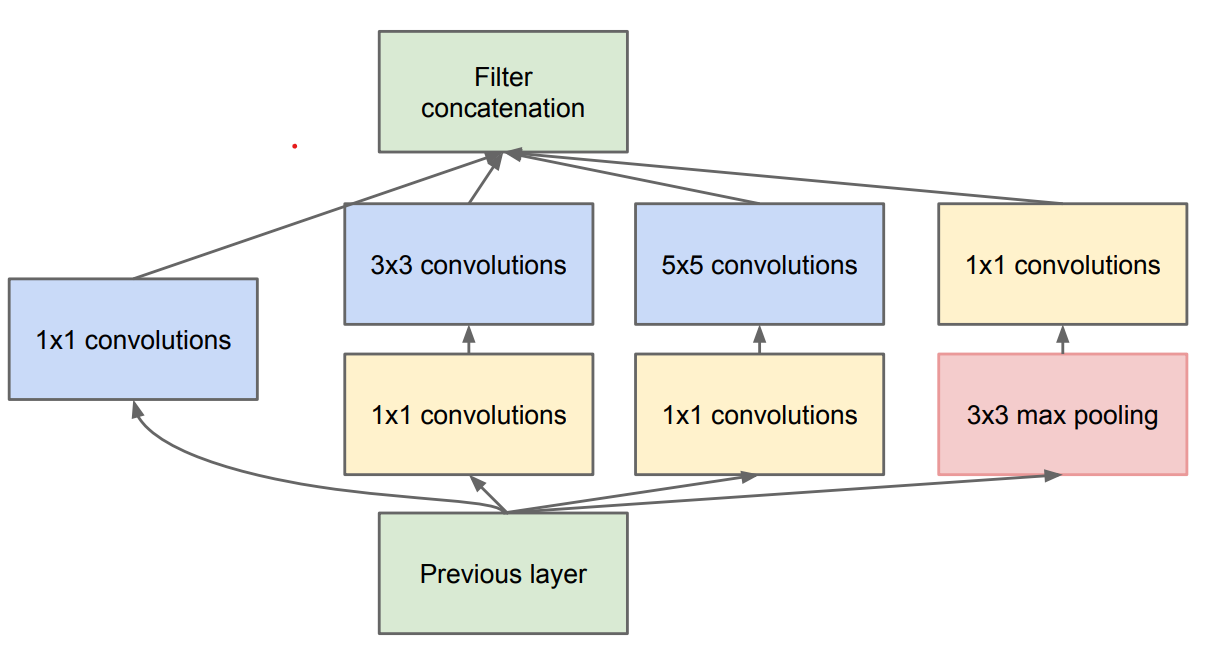

In [ ]:
class Inception(nn.Module):
    def __init__(self, in_channel, num1, reduce3, num3, reduce5, num5, pool_proj):
        super(Inception,self).__init__()

        self.block1 = Conv(in_channel, num1, 1, 1, 0)
        self.block2 = nn.Sequential(
            Conv(in_channel,reduce3 , 1, 1, 0),
            Conv(reduce3, num3, 3, 1 , 1)
        )
        self.block3 = nn.Sequential(
            Conv(in_channel, reduce5, 1,1,0),
            Conv(reduce5,num5,5,1,2)
        )
        self.block4 = nn.Sequential(
            nn.MaxPool2d(3, stride = 1, padding = 1, ceil_mode = True),
            Conv(in_channel, pool_proj, 1, 1, 0)
        )
    def forward(self,x):
      block1 = self.block1(x)
      block2 = self.block2(x)
      block3 = self.block3(x)
      block4 = self.block4(x)
      return torch.cat([block1,block2,block3,block4],1)


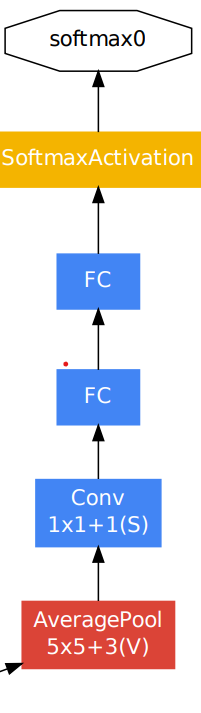

 These classifiers take the form of smaller convolutional networks put on top of the output of the Inception (4a) and (4d) modules. During training, their loss gets added to the total loss of the network with a discount weight (the losses of the auxiliary classifiers were weighted by 0.3). At inference time, these auxiliary networks are discarded

In [ ]:
class Auxillary(nn.Module):
    def __init__(self, in_channels,num_classes):
        super(Auxillary,self).__init__()
        self.pool=nn.AvgPool2d(kernel_size=5,stride = 3)

        self.conv = Conv(in_channels,128,1,1,0)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.7)
        self.fc1 = nn.Linear(2048,1024)
        self.bn_fc1 = nn.BatchNorm1d(num_features=1024)
        self.fc2 = nn.Linear(1024,num_classes)



    def forward(self,x):
            out = self.pool(x)
            out = self.conv(out)
#             out = self.activation(out)
            out = torch.flatten(out, 1)

            out = self.fc1(out)
            out = self.bn_fc1(out)
            out = self.activation(out)
            out = self.dropout(out)
#             out = self.activation(out)

            out = self.fc2(out)
            # out = self.dropout(out)
            return out


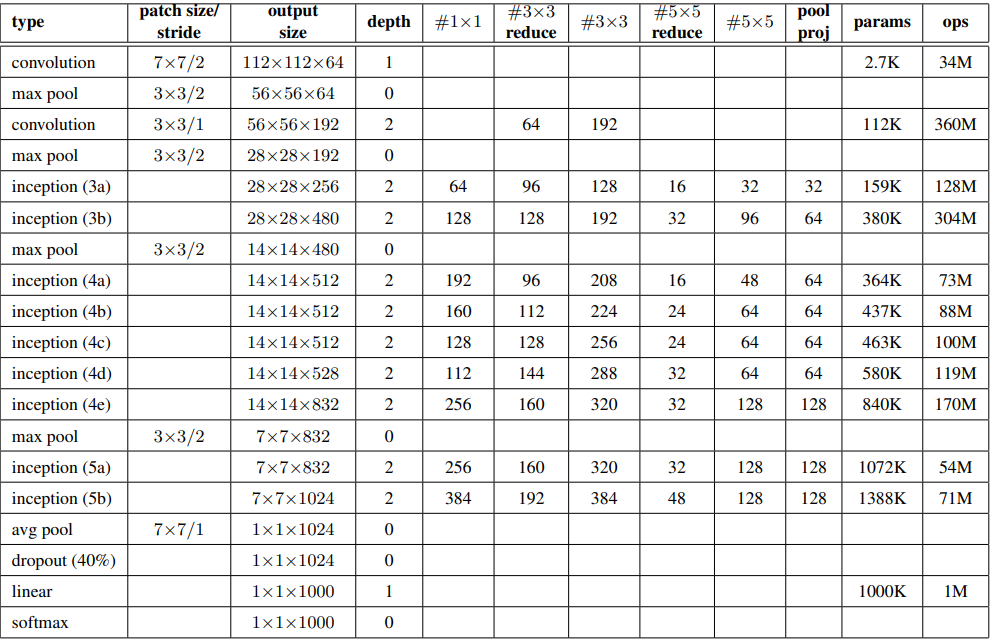

In [ ]:
"""(self, in_channel, num1, reduce3, num3, reduce5, num5, pool_proj)"""
class GoogleNett(nn.Module):
    def __init__(self,in_channel = 3,num_classes = 10 ):
        super(GoogleNett,self).__init__()
        '''self, in_channels, out_channel, kernelSize, stride, padding'''
        self.conv1 = Conv(in_channel,64,7,2,3)
        self.pool = nn.MaxPool2d(3, stride = 2, padding = 1)
#         self.conv2 = nn.MaxPool2d(3,stride = 2, padding = 1, ceil_mode = True)
        self.conv3 = Conv(64,64,1,1,0)
        self.conv4 = Conv(64,192,3,1,1)
        self.pool1 = nn.MaxPool2d(3,stride = 2, padding = 1, ceil_mode = True)
        """(self, in_channel, num1, reduce3, num3, reduce5, num5, pool_proj)"""
        self.inception3A = Inception(192,64,96,128,16,32,32)
        self.inception3B = Inception(256,128,128,192,32,96,64)
        self.pool2 = nn.MaxPool2d(3,stride = 2, padding = 1)
        self.inception4A = Inception(480,192,96,208,16,48,64)
        self.inception4B = Inception(512,160,112,224,24,64,64)
        self.inception4C = Inception(512,128,128,256,24,64,64)
        self.inception4D = Inception(512,112,144,288,32,64,64)
        self.inception4E = Inception(528,256,160,320,32,128,128)
        self.pool3 = nn.MaxPool2d(3,stride = 2, padding = 1)
        self.inception5A = Inception(832,256,160,320,32,128,128)
        self.inception5B = Inception(832,384,192,384,48,128,128)
        self.pool4 = nn.AdaptiveAvgPool2d(1)
        self.dropout= nn.Dropout(0.4)
        self.fc = nn.Linear(1024,10)
        self.aux4a = Auxillary(512,num_classes)
        self.aux4d = Auxillary(528,num_classes)
    def forward(self, x, use_aux=False):
        out = self.conv1(x)
        out = self.pool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.pool1(out)
        out = self.inception3A(out)
        out = self.inception3B(out)
        out = self.pool2(out)
        out = self.inception4A(out)
        if use_aux:
            aux1 = self.aux4a(out)
        out = self.inception4B(out)
        out = self.inception4C(out)
        out = self.inception4D(out)
        if use_aux:
             aux2 = self.aux4d(out)
        out = self.inception4E(out)

        out = self.pool3(out)
        out = self.inception5A(out)
        out = self.inception5B(out)
        out = self.pool4(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)

        out = self.fc(out)


        if use_aux:
             return out, aux1, aux2
        return out,None,None




In [ ]:
model = GoogleNett(in_channel = 1,num_classes = 10)

In [ ]:
model

GoogleNett(
  (conv1): Conv(
    (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv3): Conv(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (conv4): Conv(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
  (inception3A): Inception(
    (block1): Conv(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/100_utilities/datasets', download=True, train=True, transform=transform)
testset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/100_utilities/datasets', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 136031486.27it/s]

Extracting /content/drive/MyDrive/100_utilities/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/100_utilities/datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 50663192.73it/s]

Extracting /content/drive/MyDrive/100_utilities/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/100_utilities/datasets/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 39441623.07it/s]


Extracting /content/drive/MyDrive/100_utilities/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/100_utilities/datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8608463.07it/s]


Extracting /content/drive/MyDrive/100_utilities/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/100_utilities/datasets/MNIST/raw



In [ ]:
import torch.optim as optim

# model = GooleNett(num_classes=10)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(params=model.parameters(), lr=0.01)

In [ ]:
import torch.nn.functional as F
from tqdm import tqdm

def train_epoch(model, criterion, optimizer, train_loader, val_loader, epoch, device, use_aux):
    loss_train, loss_val = 0., 0.
    acc_train, acc_val = 0., 0.
    ntrain = len(train_loader.dataset)
    nval = len(val_loader.dataset)

    with tqdm(train_loader, unit='batches') as pbar:
        for i, (images, labels) in enumerate(pbar):
            pbar.set_description(f"Epoch {epoch}")
            images = images.to(device)
            labels = labels.to(device).to(torch.long).view(-1)

            # train and back-propagate
            optimizer.zero_grad()
            if use_aux:
                output, aux1, aux2 = model(images, use_aux)
                loss_main, loss_aux1, loss_aux2 = criterion(output, labels), criterion(aux1, labels), criterion(aux2, labels)
                loss = loss_main + 0.3*loss_aux1 + 0.3*loss_aux2    #
            else:
                output, _, _ = model(images, use_aux)
                loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            # train accuracy
            with torch.no_grad():
                probs = F.softmax(output, dim=1).cpu()
                preds = torch.max(probs, dim=1)[1]
                acc_train += (preds == labels.cpu()).sum()
                loss_train += loss.item()

            # validate
            if i % 100 == 0 or i == len(train_loader) - 1:
                loss_val, acc_val = validate(model, criterion, val_loader, device)

            if i < len(train_loader) - 1:
                denom = images.shape[0] * (i + 1)
            else:
                denom = ntrain

            pbar.set_postfix(train_loss=loss_train / denom, valid_loss=loss_val / nval,
                             train_acc=acc_train / denom, valid_acc=acc_val / nval)

    return loss_train / ntrain, loss_val / nval, acc_train / ntrain, acc_val / nval


def validate(model, criterion, val_loader, device):
  acc_val = 0.
  loss_val = 0.
  with torch.no_grad():
    for val_images, val_labels in val_loader:
      val_images = val_images.to(device)
      val_labels = val_labels.to(device).to(torch.long).view(-1)

      val_output,_,_ = model(val_images)
      val_loss = criterion(val_output, val_labels)
      loss_val += val_loss.item()

      probs = F.softmax(val_output, dim=1).cpu()
      preds = torch.max(probs, dim=1)[1]
      acc_val += (preds == val_labels.cpu()).sum()

  return loss_val, acc_val

def train(model, criterion, optimizer, train_loader, val_loader, epochs, device,use_aux=False):
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []

  for epoch in range(epochs):
    train_loss, val_loss, train_acc, val_acc = train_epoch(model, criterion, optimizer, train_loader, val_loader, epoch, device,use_aux)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

  return train_losses, val_losses, train_accs, val_accs


In [ ]:
print(torch.cuda.is_available())

True


##Without Auxillary

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
criterion = criterion.to(device)
epochs = 3

train_losses, val_losses, train_accs, val_accs = train(model, criterion.to(device), optimizer, trainloader, testloader, epochs, device,use_aux=False)

Epoch 2: 100%|██████████| 469/469 [05:44<00:00,  1.36batches/s, train_acc=tensor(0.9815), train_loss=0.0623, valid_acc=tensor(0.9845), valid_loss=0.0477]


##With Auxillary

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
criterion = criterion.to(device)
epochs = 3

train_losses, val_losses, train_accs, val_accs = train(model, criterion.to(device), optimizer, trainloader, testloader, epochs, device,use_aux=True)

Epoch 2: 100%|██████████| 469/469 [05:47<00:00,  1.35batches/s, train_acc=tensor(0.9896), train_loss=0.0615, valid_acc=tensor(0.9924), valid_loss=0.0209]


#Style Transfer


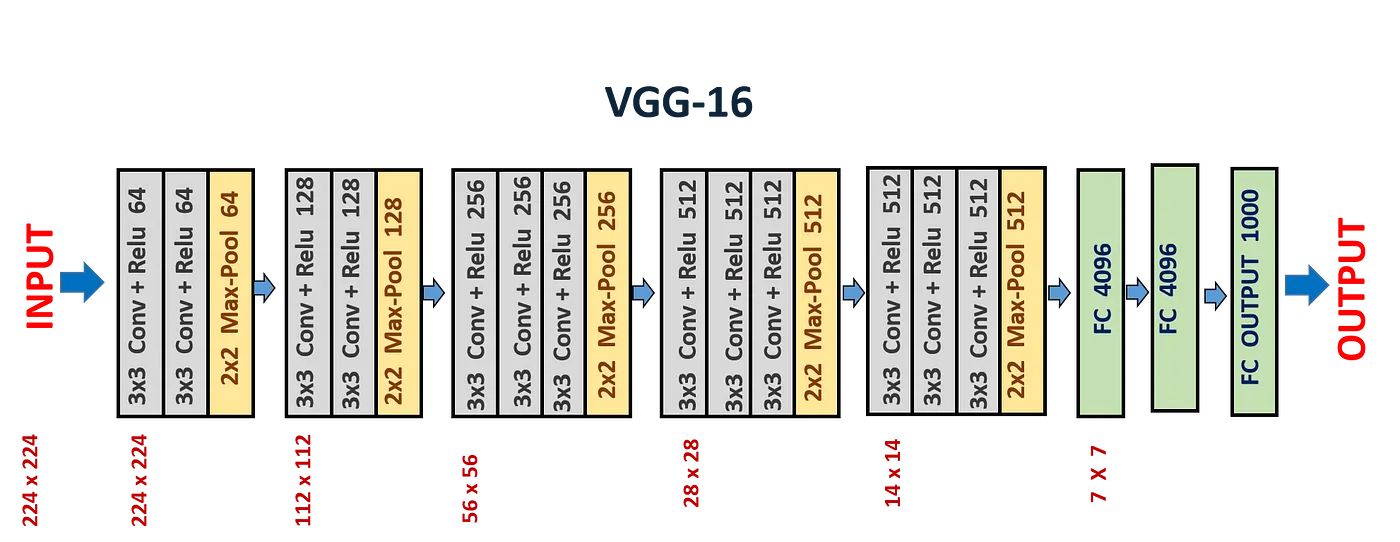

just take output from specific conv layers

these layers are

conv1-1

conv 2-1

conv3-1

conv4-1

conv 5-1

from the above we see that
conv1-1
conv 2-1
conv3-1
conv4-1
conv 5-1
are in the index 0, 5, 10,19,28

we do not consider the fc layers

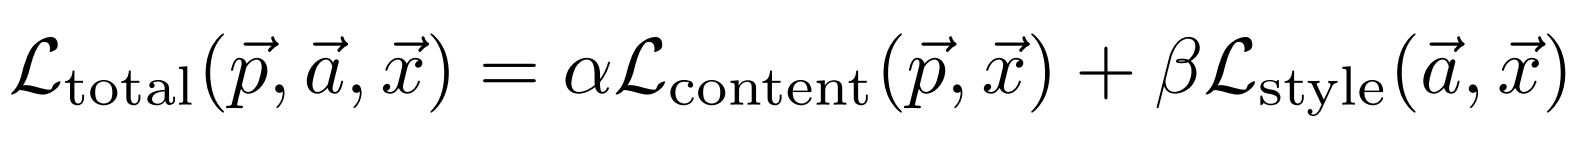

p is the content or original image, x is the generated image, and s is the style image

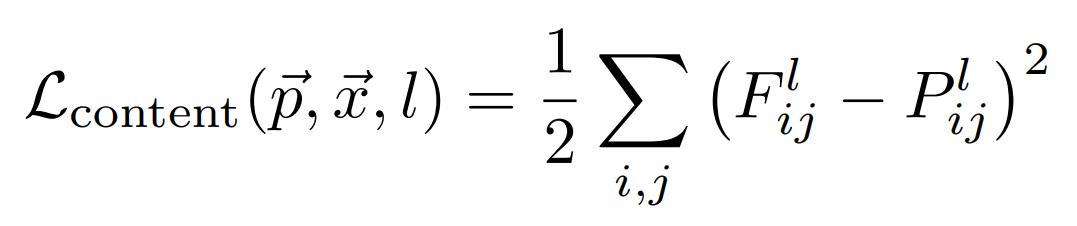

Content Loss is defined as the summation of then square of the difference of content image and generated image for every layer divided by two
F is the conent output for one of the above 5 layers

l is the one of the 5 layers

P is the generated output in one of those 5 layers


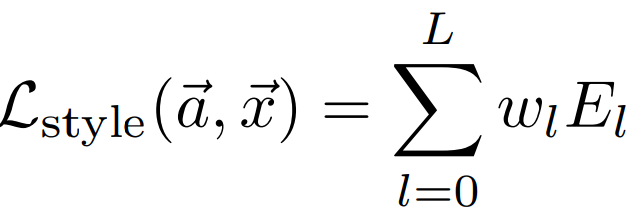

where wl are weighting factors of the contribution of each
layer to the total loss

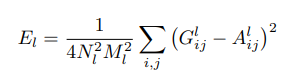

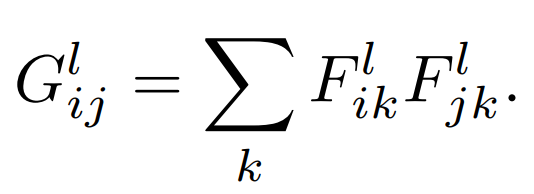

Gram matrices for generated and style images


multiply the output from a conv layer to a transpose of a conv layer


## Module Import

In [ ]:
 import torch
 import torch.nn as nn
 import torch.optim as optim
 from PIL import Image
 import torchvision.transforms as transforms
 import torchvision.models as models
 from torchvision.utils import save_image
 import matplotlib.pyplot as plt
 import numpy as np

from the above we see that
conv1-1
conv 2-1
conv3-1
conv4-1
conv 5-1
are in the index 0, 5, 10,19,28

## Device Configuration and Image Size

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
image_size = 250
print(torch.cuda.is_available())

True


## VGG Feature Extractor

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.extract_features = [0, 5, 10, 19, 28]  # Convert strings to integers
        self.model = models.vgg19(pretrained=True).features
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, output):
        features = []
        for name, layer in self.model._modules.items():  #_modules.items() is used to iterate over the layers
          if isinstance(layer, nn.MaxPool2d):
                layer = nn.AvgPool2d(kernel_size=2, stride=2)
          output = layer(output)
          if int(name) in self.extract_features:
            features.append(output)
#         print(features)
        return features




In [ ]:
model = VGG().to(device).eval()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 173MB/s]  


## Image Loading and Preprocessing

In [ ]:
def load_image(image_name,is_Content,mean,std):
    image = Image.open(image_name)
    original_image = np.array(image)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Define transforms to convert the image to tensor and normalize it
    loader = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    # Convert the image to tensor
    image_tensor = loader(image).unsqueeze(0).to(device)
    normalize_transform = transforms.Normalize(mean=mean, std=std) #image = ((image * std) + mean)

    normalized_image = normalize_transform(image_tensor)
    print("Loaded image shape:", normalized_image.shape)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot original image
    axes[0].imshow(original_image)
    if is_Content:
        axes[0].set_title('Original Content Image')
    else:
        axes[0].set_title('Original Style Image')
    axes[0].axis('off')

    # Plot normalized image
    axes[1].imshow(np.transpose(normalized_image.squeeze().cpu().numpy(), (1, 2, 0)))
    if is_Content:
        axes[1].set_title('Normalized Content Image')
    else:
        axes[1].set_title('Normalized Style Image')
    axes[1].axis('off')

    plt.show()

    return normalized_image, mean, std


Eg for unsqueeze(0): mainly used for changing dimension of input..passing the image with batchsize of 1
```
a = torch.rand(3, 226, 226)
b = a.unsqueeze(0)
print(a.shape)
print(b.shape)
```
torch.Size([3, 226, 226])

torch.Size([1, 3, 226, 226])

The unsqueeze() method adds a dimension of extent 1. unsqueeze(0) adds it as a new zeroth dimension - to have a batch of one!



Loaded image shape: torch.Size([1, 3, 250, 250])


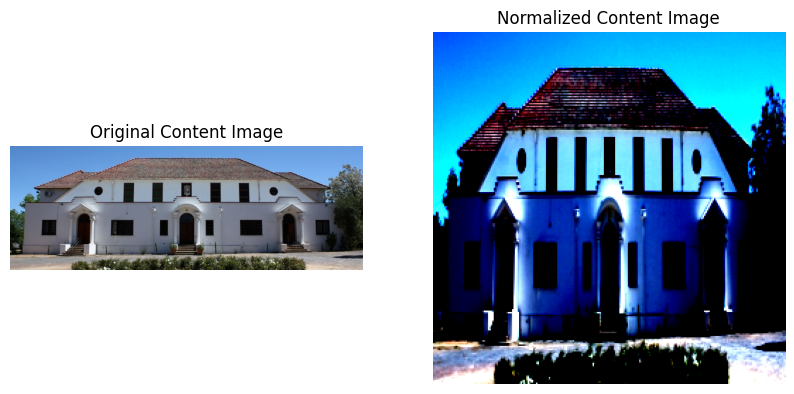

Loaded image shape: torch.Size([1, 3, 250, 250])


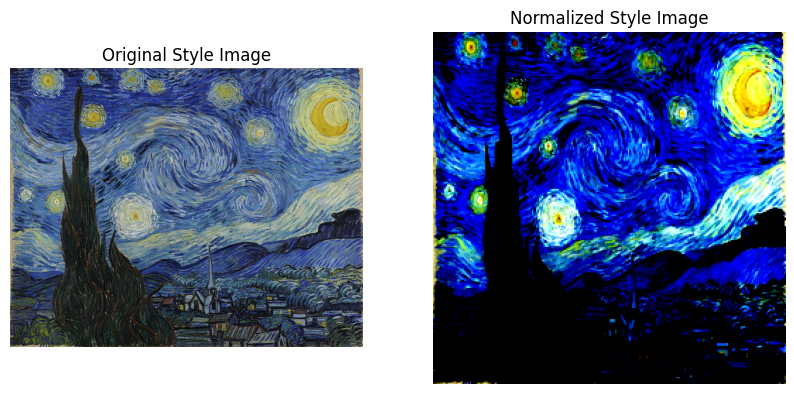

In [ ]:
#input of the images
original_img, org_mean, org_std = load_image("/kaggle/input/styletransferdata/First_Love_Church_Building.jpg",True,_,_)
style_img,style_mean,style_std = load_image("/kaggle/input/styletransferdata/stlejpg.jpg",False,org_mean,org_std)
# generated = original_img.clone().requires_grad_(True)
generated = torch.randn(original_img.shape, device = device, requires_grad=True) # freeze the network and only thing that will change is the generated image

In [ ]:
print(org_mean)

[0.485, 0.456, 0.406]


In [ ]:
style_mean

[0.485, 0.456, 0.406]

## Generation of the below image

![Image](https://i.imgur.com/XAVUQwS.jpeg)

## Optimization Parameters

In [ ]:
total_steps = 2500
learning_rate = 0.01
alpha = 1.
beta = 5000000.

## Main Crux

In [ ]:
optimizer = optim.Adam([generated], lr = learning_rate)

In [ ]:
#calculating gram matrix for using it in the style loss
def gram_matrix(input, c, h, w):
  input = input.view(c, h*w)
  G = torch.mm(input, input.t())
  return G

Step 0, Total Loss: 163.73672485351562


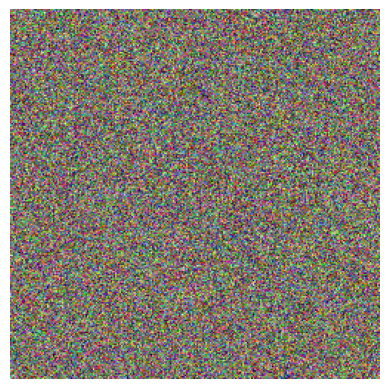

Step 500, Total Loss: 3.984872817993164


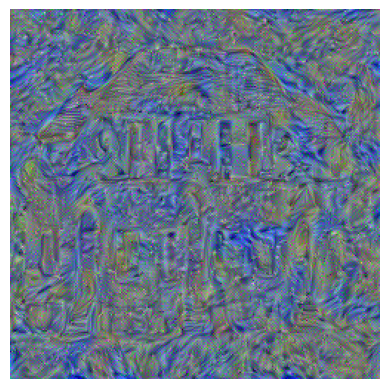

Step 1000, Total Loss: 2.5575039386749268


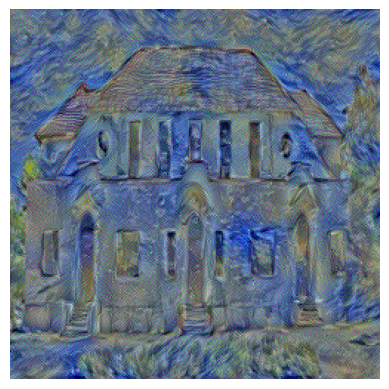

Step 1500, Total Loss: 1.9899388551712036


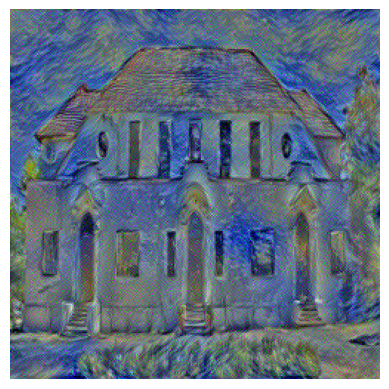

Step 2000, Total Loss: 1.6967487335205078


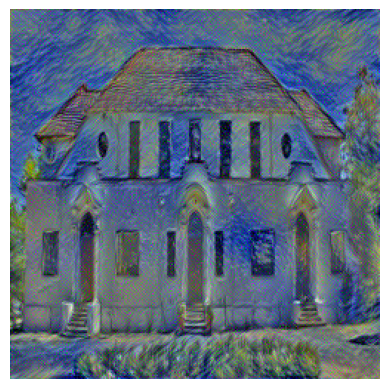

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#initializations
total_loss = 0
i = 0
content_losses = []
style_losses = []
total_losses = []

for step in range(total_steps):
    #feature extractions
    generated_features = model(generated)
    original_img_features = model(original_img)
    style_features = model(style_img)

    #initializations
    style_loss = original_loss = 0

    for gen_features, orig_features, st_features in zip(generated_features, original_img_features, style_features):
        batch_size, channel, height, width = gen_features.shape
        # Calculating content loss
        original_loss += torch.mean((gen_features - orig_features) ** 2)/2
        G = gram_matrix(gen_features,channel,height,width)
        A = gram_matrix(st_features,channel,height,width)
        #calculating style loss
        style_loss += torch.mean((G - A) ** 2)/((2*channel*height*width)**2)

    #calculating total loss
    total_loss = alpha * original_loss + beta * style_loss

    optimizer.zero_grad()  # Zero gradients before backward pass
    total_loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    #appending losses to plot the graph
    content_losses.append(original_loss.item())
    style_losses.append(style_loss.item())
    total_losses.append(total_loss.item())
    if step % 500 == 0:
        print(f"Step {step}, Total Loss: {total_loss.item()}")
        generated_np = generated.detach().cpu().numpy().squeeze().transpose((1, 2, 0))
#         Denormalize the generated image
        denormalized_generated = generated_np * np.array(org_std) + np.array(org_mean)
        plt.imshow(np.clip(denormalized_generated, 0, 1))
        plt.axis('off')
        plt.show()



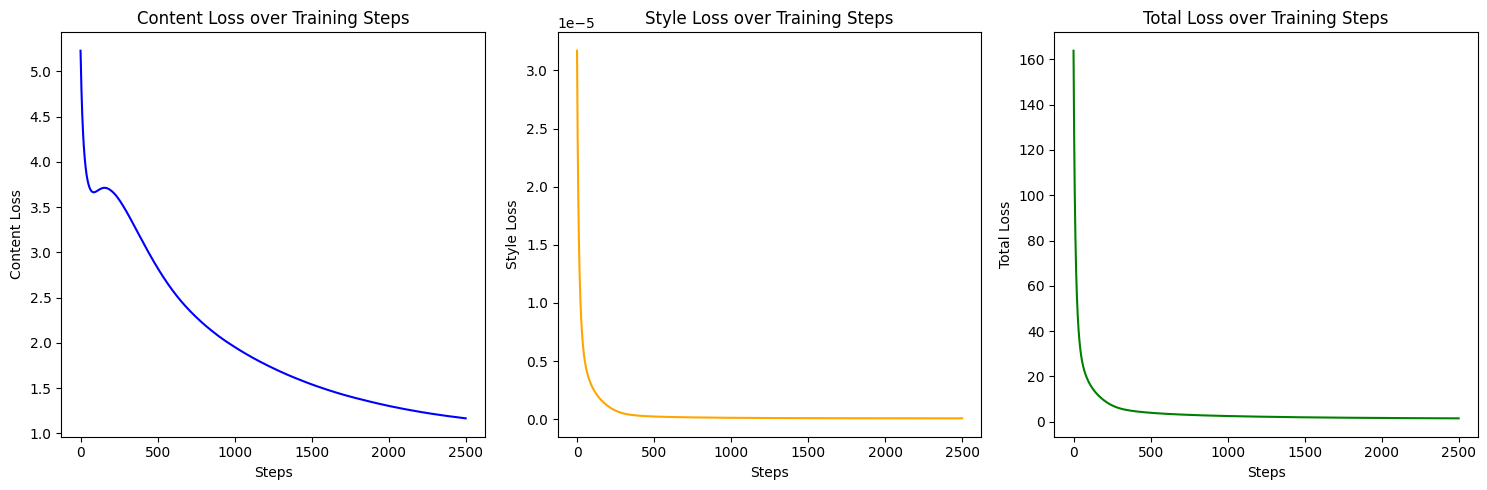

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot Content Loss
axs[0].plot(content_losses, label='Content Loss', color='blue')
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Content Loss')
axs[0].set_title('Content Loss over Training Steps')

# Plot Style Loss
axs[1].plot(style_losses, label='Style Loss', color='orange')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Style Loss')
axs[1].set_title('Style Loss over Training Steps')

# Plot Total Loss
axs[2].plot(total_losses, label='Total Loss', color='green')
axs[2].set_xlabel('Steps')
axs[2].set_ylabel('Total Loss')
axs[2].set_title('Total Loss over Training Steps')

plt.tight_layout()
plt.show()